In [58]:
# Import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,f1_score
import warnings
warnings.filterwarnings('ignore')

In [59]:
df = pd.read_csv('costumer.csv') 
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


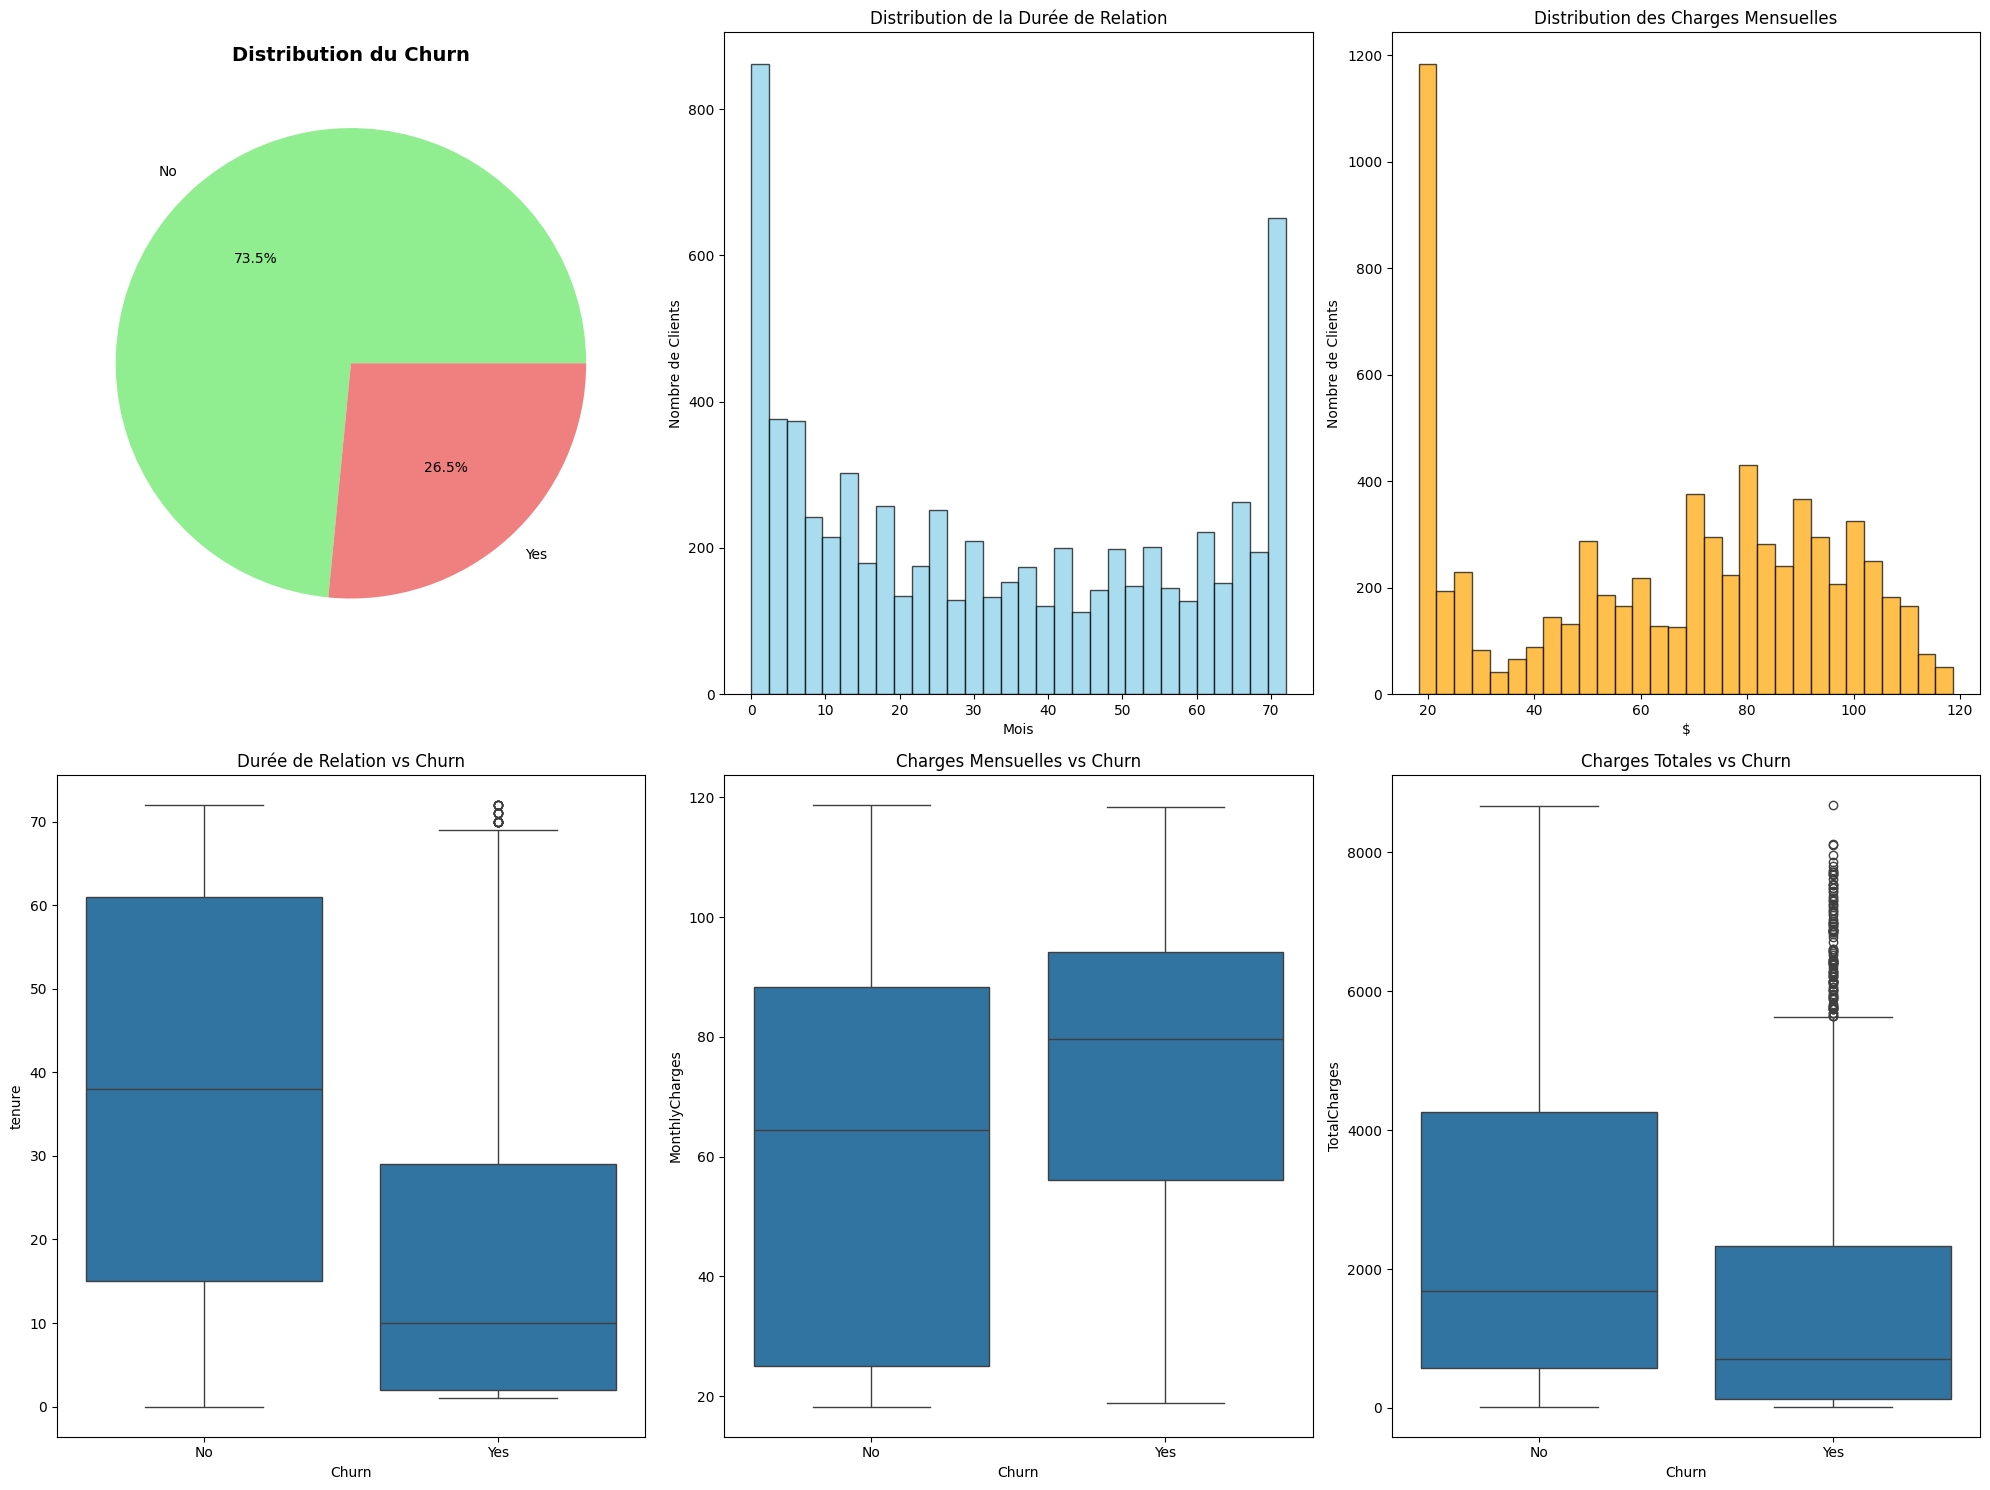

In [61]:

 # 1. Distribution de la variable cible
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    
    # Distribution du Churn
churn_counts = df['Churn'].value_counts()
axes[0,0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
axes[0,0].set_title('Distribution du Churn', fontsize=14, fontweight='bold')
# Distribution de la tenure
axes[0,1].hist(df['tenure'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].set_title('Distribution de la Durée de Relation', fontsize=12)
axes[0,1].set_xlabel('Mois')
axes[0,1].set_ylabel('Nombre de Clients')
    
    # Distribution des charges mensuelles
axes[0,2].hist(df['MonthlyCharges'], bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0,2].set_title('Distribution des Charges Mensuelles', fontsize=12)
axes[0,2].set_xlabel('$')
axes[0,2].set_ylabel('Nombre de Clients')

 # 2. Analyse bivariée - Churn vs Variables importantes
    # Tenure vs Churn
sns.boxplot(data=df, x='Churn', y='tenure', ax=axes[1,0])
axes[1,0].set_title('Durée de Relation vs Churn', fontsize=12)
    
    # MonthlyCharges vs Churn
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', ax=axes[1,1])
axes[1,1].set_title('Charges Mensuelles vs Churn', fontsize=12)
    
    # TotalCharges vs Churn
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
sns.boxplot(data=df, x='Churn', y='TotalCharges', ax=axes[1,2])
axes[1,2].set_title('Charges Totales vs Churn', fontsize=12)
    
plt.tight_layout()
plt.show()



In [62]:
# Préparation des données pour la corrélation
df_corr = df.copy()
df_corr['TotalCharges'] = pd.to_numeric(df_corr['TotalCharges'], errors='coerce')
df_corr = df_corr.drop('customerID', axis=1)
df_corr['Churn'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})


In [63]:
# Encodage des variables catégorielles
categorical_cols = df_corr.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df_corr[col] = le.fit_transform(df_corr[col].astype(str))

In [64]:
df_corr = df_corr.fillna(df_corr.median())

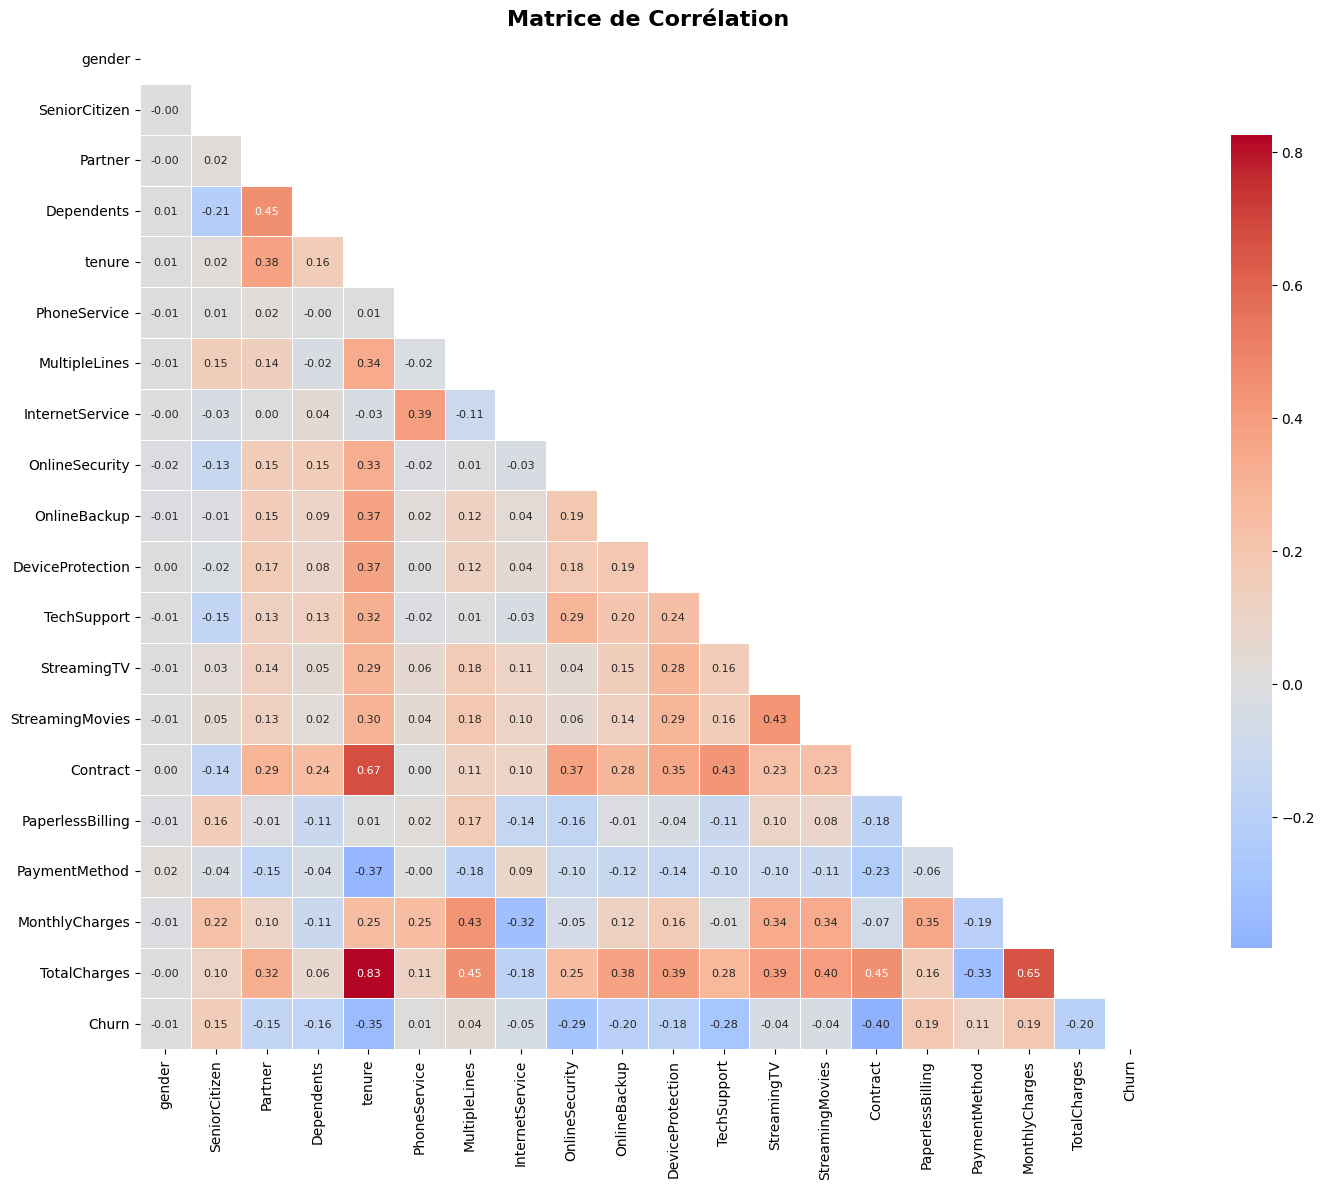

In [65]:
# Matrice de corrélation
plt.figure(figsize=(16, 12))
correlation_matrix = df_corr.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f',
            annot_kws={'size': 8})
plt.title('Matrice de Corrélation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

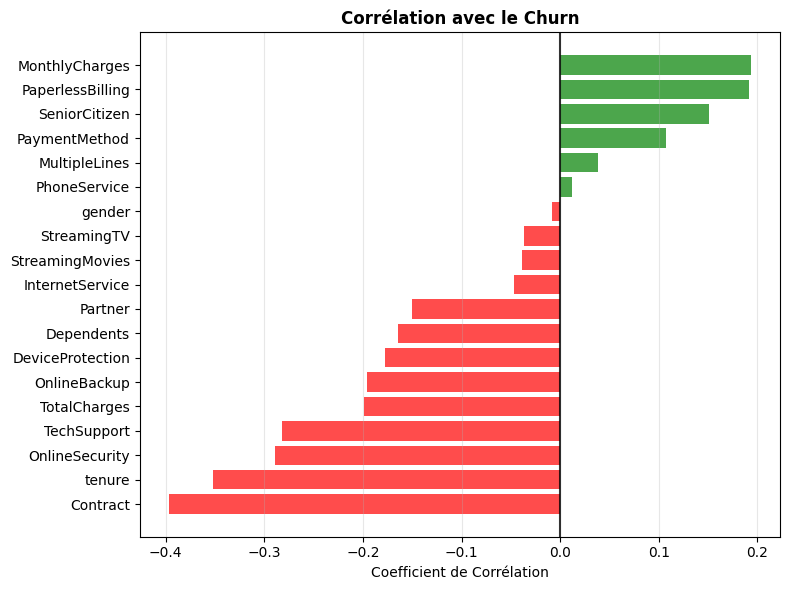

In [66]:
# Corrélations avec le Churn
plt.figure(figsize=(8, 6))
churn_corr = correlation_matrix['Churn'].drop('Churn').sort_values(ascending=True)
colors = ['red' if x < 0 else 'green' for x in churn_corr.values]
plt.barh(range(len(churn_corr)), churn_corr.values, color=colors, alpha=0.7)
plt.yticks(range(len(churn_corr)), churn_corr.index)
plt.xlabel('Coefficient de Corrélation')
plt.title('Corrélation avec le Churn', fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.8)
plt.tight_layout()
plt.show()

In [67]:
# 🧹 NETTOYAGE DES DONNÉES
df_clean = df.copy()


In [68]:
# Conversion de TotalCharges
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

In [69]:
# Suppression des lignes avec valeurs manquantes
df_clean = df_clean.dropna()
print(f"✅ Données nettoyées: {df_clean.shape}")

✅ Données nettoyées: (7032, 21)


In [70]:
print(f"📊 Churn après nettoyage: {df_clean['Churn'].value_counts().to_dict()}")


📊 Churn après nettoyage: {'No': 5163, 'Yes': 1869}


In [71]:
# ⚙️ PRÉPARATION DES FEATURES
X = df_clean.drop(['customerID', 'Churn'], axis=1)
y = df_clean['Churn'].map({'Yes': 1, 'No': 0})

print(f"📋 Features: {X.shape[1]} variables")
print(f"🎯 Target: {y.value_counts().to_dict()}")

📋 Features: 19 variables
🎯 Target: {0: 5163, 1: 1869}


In [72]:
# Encodage des variables catégorielles
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"🔧 {len(categorical_cols)} variables catégorielles à encoder")

🔧 15 variables catégorielles à encoder


In [73]:
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

In [74]:
# ⚖️ UNDER SAMPLING
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X, y)

print("📊 AVANT UnderSampling:")
print(f"Classes: {pd.Series(y).value_counts().to_dict()}")
print(f"Taux churn: {y.mean():.2%}")

print("\n📊 APRÈS UnderSampling:")
print(f"Classes: {pd.Series(y_under).value_counts().to_dict()}")
print(f"Taux churn: {y_under.mean():.2%}")

📊 AVANT UnderSampling:
Classes: {0: 5163, 1: 1869}
Taux churn: 26.58%

📊 APRÈS UnderSampling:
Classes: {0: 1869, 1: 1869}
Taux churn: 50.00%


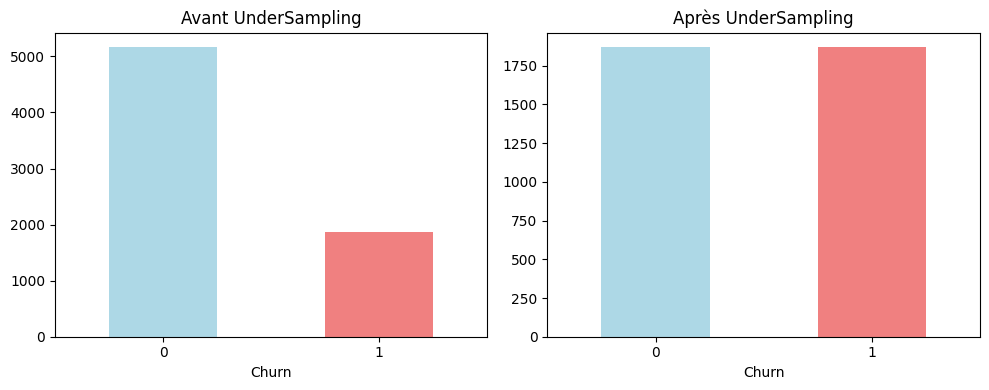

In [75]:
# Visualisation
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
y.value_counts().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Avant UnderSampling')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
y_under.value_counts().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Après UnderSampling')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [76]:
# 🎯 SPLIT DES DONNÉES
X_train, X_test, y_train, y_test = train_test_split(
    X_under, y_under, test_size=0.2, random_state=42, stratify=y_under
)

print(f"📊 Dataset UnderSampling complet: {X_under.shape}")
print(f"🔧 Training set: {X_train.shape}")
print(f"🧪 Test set: {X_test.shape}")
print(f"🎯 Distribution training: {pd.Series(y_train).value_counts().to_dict()}")

📊 Dataset UnderSampling complet: (3738, 19)
🔧 Training set: (2990, 19)
🧪 Test set: (748, 19)
🎯 Distribution training: {0: 1495, 1: 1495}


In [77]:
# 🤖 ENTRAÎNEMENT DES MODÈLES
from xgboost import XGBClassifier

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

print("🚀 ENTRAÎNEMENT DES MODÈLES...")
print("="*40)

🚀 ENTRAÎNEMENT DES MODÈLES...


In [78]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"✅ {name} entraîné")

print("\n🎯 TOUS LES MODÈLES SONT ENTRÂINÉS !")

✅ Logistic Regression entraîné
✅ Random Forest entraîné
✅ XGBoost entraîné

🎯 TOUS LES MODÈLES SONT ENTRÂINÉS !


In [79]:
# 📊 ÉVALUATION DES MODÈLES
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix
results = {}

print("📈 PERFORMANCES DES MODÈLES")
print("="*50)


for name, model in models.items():
    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Métriques
    results[name] = {
        'f1': f1_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print(f"\n🔍 {name}:")
    print(f"   F1-Score: {results[name]['f1']:.3f}")
    print(f"   Recall: {results[name]['recall']:.3f}")
    print(f"   Precision: {results[name]['precision']:.3f}")
    print(f"   AUC-ROC: {results[name]['auc']:.3f}")
    

📈 PERFORMANCES DES MODÈLES

🔍 Logistic Regression:
   F1-Score: 0.752
   Recall: 0.757
   Precision: 0.747
   AUC-ROC: 0.827

🔍 Random Forest:
   F1-Score: 0.733
   Recall: 0.738
   Precision: 0.728
   AUC-ROC: 0.810

🔍 XGBoost:
   F1-Score: 0.718
   Recall: 0.730
   Precision: 0.707
   AUC-ROC: 0.796


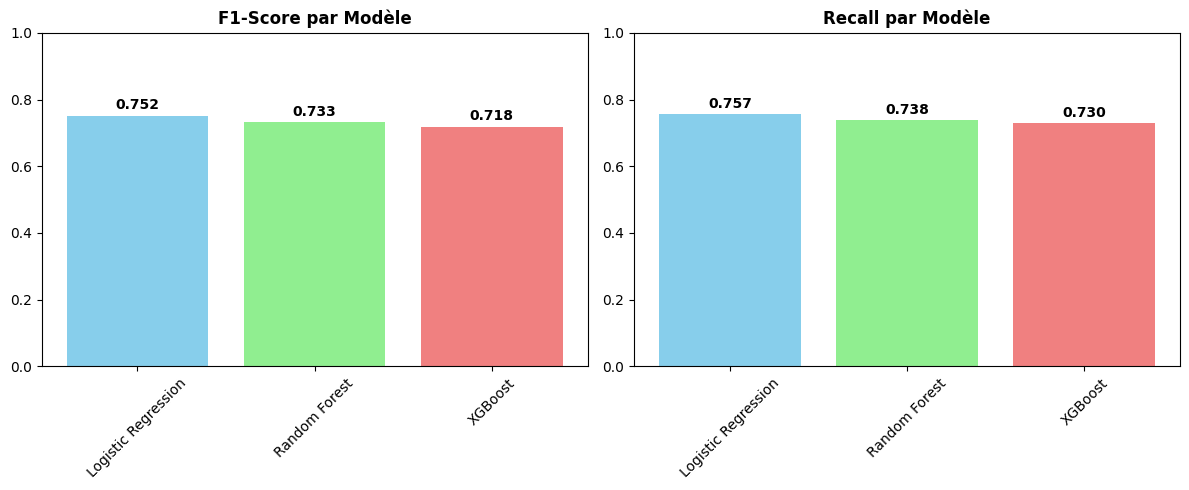

In [80]:
# 📊 VISUALISATION DES PERFORMANCES
models_names = list(results.keys())
f1_scores = [results[name]['f1'] for name in models_names]
recall_scores = [results[name]['recall'] for name in models_names]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(models_names, f1_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('F1-Score par Modèle', fontweight='bold')
plt.ylim(0, 1)
plt.xticks(rotation=45)
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 2, 2)
bars = plt.bar(models_names, recall_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Recall par Modèle', fontweight='bold')
plt.ylim(0, 1)
plt.xticks(rotation=45)
for bar, score in zip(bars, recall_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

🏆 MEILLEUR MODÈLE SÉLECTIONNÉ
📊 Modèle: Logistic Regression
🎯 F1-Score: 0.752
📈 Recall: 0.757
🎯 Precision: 0.747
📊 AUC-ROC: 0.827


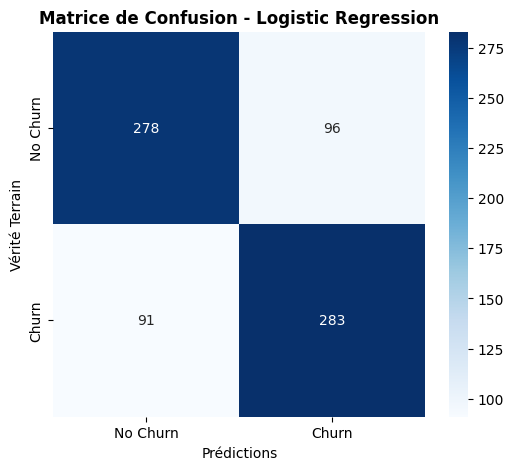

In [81]:
# 🏆 SÉLECTION DU MEILLEUR MODÈLE
best_model_name = max(results.items(), key=lambda x: x[1]['f1'])[0]
best_model = models[best_model_name]
best_performance = results[best_model_name]

print("🏆 MEILLEUR MODÈLE SÉLECTIONNÉ")
print("="*40)
print(f"📊 Modèle: {best_model_name}")
print(f"🎯 F1-Score: {best_performance['f1']:.3f}")
print(f"📈 Recall: {best_performance['recall']:.3f}")
print(f"🎯 Precision: {best_performance['precision']:.3f}")
print(f"📊 AUC-ROC: {best_performance['auc']:.3f}")

# Matrice de confusion du meilleur modèle
plt.figure(figsize=(6, 5))
cm = best_performance['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Matrice de Confusion - {best_model_name}', fontweight='bold')
plt.ylabel('Vérité Terrain')
plt.xlabel('Prédictions')
plt.show()

In [82]:
# Ajoutez ce code APRÈS l'entraînement de Logistic Regression
import joblib

# Sauvegarde du modèle et des features
joblib.dump(best_model, 'meilleur_modele_churn.pkl')
joblib.dump(X.columns, 'feature_names.pkl')

print("✅ Modèle sauvegardé pour Streamlit")

✅ Modèle sauvegardé pour Streamlit
